# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Read Data

In [2]:
# Form list of file paths for train and test data
train_filenames = os.listdir("../database/anomaly_detection_data/train/")
train_filenames = [f"../database/anomaly_detection_data/train/{item}" for item in train_filenames]

test_filenames = os.listdir("../database/anomaly_detection_data/test/")
test_filenames = [f"../database/anomaly_detection_data/test/{item}" for item in test_filenames]

In [3]:
# Read column names
raw_df = pd.read_csv("../database/anomaly_detection_data/train/data_0.csv")
columns = raw_df.columns.tolist()

In [4]:
# Form train and test dataframes and populate them
train_df = pd.DataFrame(columns=columns)
test_df = pd.DataFrame(columns=columns)

for path in train_filenames:
    df = pd.read_csv(path)
    train_df=train_df.append(df)

for path in test_filenames:
    df = pd.read_csv(path)
    test_df=test_df.append(df)

In [5]:
# Reset index
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Data Cleaning

In [6]:
# Drop duplicates
train_df.drop_duplicates(inplace=True)

# Check for missing valeus
print(train_df.isna().sum())

x                  0
y                  0
z                  0
010-000-024-033    0
010-000-030-096    0
020-000-032-221    0
020-000-033-111    0
anomaly            0
dtype: int64


In [7]:
# Check datatypes
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134229 entries, 0 to 134228
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   x                134229 non-null  object
 1   y                134229 non-null  object
 2   z                134229 non-null  object
 3   010-000-024-033  134229 non-null  object
 4   010-000-030-096  134229 non-null  object
 5   020-000-032-221  134229 non-null  object
 6   020-000-033-111  134229 non-null  object
 7   anomaly          134229 non-null  object
dtypes: object(8)
memory usage: 9.2+ MB
None


### From observation, we can see that 'x', 'y', 'z' are numeric columns and the remaining are categorical columns
### Let us convert these to numeric and categorical datatypes

In [8]:
numeric_col = ['x', 'y', 'z']
categorical_col = [ '010-000-024-033', '010-000-030-096', '020-000-032-221', '020-000-033-111', 'anomaly']
# convert to numeric
for col in numeric_col:
    train_df[col] = pd.to_numeric(train_df[col])

# convert to categorical
for col in categorical_col:
    train_df[col] = train_df[col].astype('category')

<AxesSubplot:>

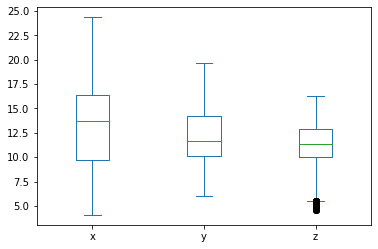

In [9]:
# Check outliers
train_df[['x', 'y', 'z']].plot(kind='box')

We see there are outliers for column 'z'. Let us remove the **outliers**

In [10]:
# Calculate values to deal with outliers
q1 = train_df.z.quantile(0.25)    # 25th quartile
q3 = train_df.z.quantile(0.75)    # 75th quartile
iqr = q3-q1                       # inter quartile range
max_z = q3 + 1.5*iqr              # permissible maximum
min_z = q1 - 1.5*iqr              # permissible minimum

def process_outlier(value, max_val, min_val):
    """Function to replace the outlier values with permissible maximum and minimum values"""
    if value > max_val:
        return max_val
    elif value < min_val:
        return min_val
    else:
        return value

# apply the function to process outliers for the 'z' column
train_df.z=train_df.z.apply(lambda x: process_outlier(x, max_z, min_z))

<AxesSubplot:>

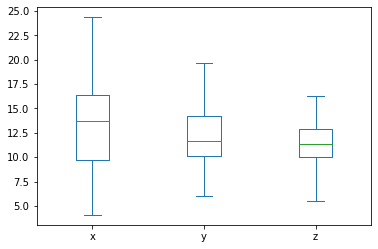

In [11]:
# recheck outliers
train_df[['x', 'y', 'z']].plot(kind='box')

# Form features and target

In [12]:
# Form features and target
features = train_df[columns[:-1]]
target = train_df['anomaly']

# Form train and validation split

In [13]:
# Form train and validation split
train_x, val_x, train_y, val_y = train_test_split(features, target, test_size=0.2, random_state=42)

# Scale the data

In [14]:
# Scale the data
scaler = StandardScaler()

In [15]:
train_x[numeric_col] = scaler.fit_transform(train_x[numeric_col])
val_x[numeric_col] = scaler.transform(val_x[numeric_col])

# Create Model, Train and Evaluate

In [16]:
# for anomaly detection model
anomaly_model = IsolationForest(n_estimators=400, contamination=0.2)
anomaly_model.fit(train_x)

# evaluate for validation data
y_pred = anomaly_model.predict(val_x)
y_pred = [1 if item==-1 else 0 for item in y_pred]


print(classification_report(y_pred, val_y))
print(precision_score(y_pred, val_y))
print(recall_score(y_pred, val_y))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87     21456
           1       0.27      0.07      0.11      5390

    accuracy                           0.78     26846
   macro avg       0.54      0.51      0.49     26846
weighted avg       0.70      0.78      0.72     26846

0.27230411171450736
0.06512059369202226


In [17]:
# Evaluate on test data

numeric_col = ['x', 'y', 'z']
categorical_col = [ '010-000-024-033', '010-000-030-096', '020-000-032-221', '020-000-033-111', 'anomaly']
# convert to numeric
for col in numeric_col:
    test_df[col] = pd.to_numeric(test_df[col])

# convert to categorical
for col in categorical_col:
    test_df[col] = test_df[col].astype('category')

# feature and target
test_features = test_df[columns[:-1]]
test_target = test_df['anomaly']

# scale
test_features[numeric_col] = scaler.transform(test_features[numeric_col])

# predict
test_pred = anomaly_model.predict(test_features)
test_pred = [1 if value==-1 else 0 for value in test_pred]

# evaluate
print(classification_report(test_pred, test_target))

              precision    recall  f1-score   support

           0       0.66      0.96      0.78     19649
           1       0.49      0.08      0.13     10381

    accuracy                           0.65     30030
   macro avg       0.57      0.52      0.46     30030
weighted avg       0.60      0.65      0.56     30030



---
---
# Author
Shounak Deshpande <br>
shounak.python@gmail.com